## **Carga de librerias para extraer vector de imagen**

In [28]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
from scipy.signal import medfilt, find_peaks
import base64
from io import BytesIO


## **Carga de librerias para preprocesamiento y evaluación de modelo**

In [29]:
import wfdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.signal import resample
import tensorflow as tf
from tensorflow.keras.models import load_model
from scipy.signal import argrelextrema

## **Definición de funciones**

### **Funciones para la extracción del vector de datos de la imagen**

In [30]:
def load_base64_from_txt(input_file):
    with open(input_file, 'r') as file:
        image_base64_str = file.read()
    return image_base64_str
    
def load_image(image_base64):
    # Decodifica la imagen en formato base64
    img_data = base64.b64decode(image_base64)
    
    # Convierte los datos decodificados en un objeto de imagen
    img = Image.open(BytesIO(img_data))
    display(img)
    return img

def to_grayscale(img):
    # Convierte la imagen a escala de grises y devuelve la imagen en escala de grises
    return img.convert('L')

def apply_threshold(img_grayscale, threshold_value=200):
    # Aplica un umbral a la imagen en escala de grises y devuelve la imagen binarizada
    return img_grayscale.point(lambda x: 0 if x < threshold_value else 255, '1')

def invert_image(img_binary):
    # Invierte los colores de la imagen binarizada y devuelve la imagen invertida
    img_array = np.array(img_binary).astype(np.uint8)
    return Image.fromarray(255 - img_array)

def crop_bottom_section(image, y_factor=0.715, height_factor=0.2):
    # Normaliza la imagen y recorta la sección inferior en función de los factores proporcionados
    img_norm = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)
    height, width = image.shape[:2]
    x = 65
    y = int(height * y_factor)
    w = width-130
    h = int(height * height_factor)
    return img_norm[y:y+h, x:x+w]

def binarize_image(image, threshold=140):
    # Binariza la imagen utilizando el valor de umbral proporcionado
    _, binary_image = cv2.threshold(image, threshold, 255, cv2.THRESH_BINARY)
    return binary_image

def ecg_vector_from_binary(binary_image):
    # Extrae el vector ECG de la imagen binaria
    white_points = np.where(binary_image == 255)
    x_coords = white_points[1]
    y_coords = white_points[0]
    height, _ = binary_image.shape

    unique_x_coords = np.unique(x_coords)
    y_values = np.zeros(unique_x_coords.shape, dtype=np.float64)

    for i, x in enumerate(unique_x_coords):
        y_for_x = y_coords[np.where(x_coords == x)]
        y_values[i] = np.max(y_for_x)

    y_values_inverted = height - y_values
    ecg_vector = y_values_inverted.astype(np.float64)
    return ecg_vector

def smooth_ecg_vector(ecg_vector, window_size=7):
    # Suaviza el vector ECG utilizando un filtro de mediana con un tamaño de ventana específico
    return medfilt(ecg_vector, window_size)

def detect_peaks(ecg_vector, prominence=20, min_distance=50):
    # Detecta picos en el vector ECG utilizando la prominencia y la distancia mínima proporcionadas
    peaks, _ = find_peaks(ecg_vector, prominence=prominence, distance=min_distance)
    return peaks

def plot_ecg(ecg_vector, peaks=None):
    # Grafica el vector ECG y, si se proporcionan, los picos detectados
    plt.figure(figsize=(15, 3))
    plt.plot(ecg_vector)
    if peaks is not None:
        plt.plot(peaks, ecg_vector[peaks], "x")
    plt.ylabel('ECG Amplitude')
    plt.xlabel('Time')
    plt.show()
    
def grafica_vector(vector):
    plt.figure(figsize=(15, 2))
    plt.plot(vector)
    plt.xlabel("Muestras")
    plt.ylabel("Amplitud")
    plt.title("Vector ECG")
    plt.grid(True)
    plt.show()


#FUNCIÓN PRINCIPAL
def process_image(image_base64,val1, val2):
    img = load_image(image_base64)
    img_grayscale = to_grayscale(img)
    img_binary = apply_threshold(img_grayscale, threshold_value=val1)
    img_inverted = invert_image(img_binary)
    image = np.array(img_inverted).astype(np.uint8)
    bottom_section = crop_bottom_section(image)
    binary_image = binarize_image(bottom_section, threshold=val2)    
    ecg_vector = ecg_vector_from_binary(binary_image)

    return ecg_vector, int(len(ecg_vector)/10)

### **Funciones para el preprocesado del vector previo a pasar al modelo**

In [31]:
def record_a_vector(record):
    vector = np.squeeze(record.p_signal) # Quita las dimensiones innecesarias del array (de 2D a 1D)
    return vector

def remuestreo_inicial(vector_original, fs_original, fs_nueva):
    # Calcular la cantidad de muestras en el nuevo vector
    n_muestras_original = len(vector_original)
    n_muestras_nueva = int(n_muestras_original * fs_nueva / fs_original)

    # Remuestrear el vector
    vector_remuestreado = resample(vector_original, n_muestras_nueva)

    return vector_remuestreado

def normalizar_vector(vector):
    minimo = np.min(vector)
    maximo = np.max(vector)
    vector_normalizado = (vector - minimo) / (maximo - minimo)
    return vector_normalizado

def derivar_vector(vector):
    derivada = np.gradient(vector)
    return derivada

def eliminar_valores_negativos(vector):
    vector_sin_negativos = np.clip(vector, 0, None) # Los valores menores de 0 se reemplazan con 0
    return vector_sin_negativos

def media_latidos(indices):
    # Calcular las diferencias entre los índices consecutivos de los máximos
    diferencias = np.diff(indices)

    # Calcular la media de las diferencias
    media_diferencias = np.mean(diferencias)
    
    return media_diferencias

def comparar(a, b):
    return a > b

def encontrar_maximos(vector, umbral, distancia_minima):
    # Encontrar los índices de los máximos locales que superan el umbral
    indices_maximos = argrelextrema(vector, comparar, order=distancia_minima)

    # Filtrar los máximos locales para asegurar que superen el umbral
    indices_filtrados = [indice for indice in indices_maximos[0] if vector[indice] > umbral]

    return np.array(indices_filtrados)

def extraer_segmentos_10seg(vector, indices_maximos, media):
    segmentos = []
    ventana = int(media / 2)
    
    for indice in indices_maximos:
        inicio = indice - ventana
        fin = indice + ventana
        
        # Verificar si hay suficientes muestras a la izquierda y a la derecha del índice
        if inicio >= 0 and fin < len(vector):
            segmento = vector[inicio:fin]
            segmentos.append(segmento)
    
    return segmentos

def ajustar_longitud(segmentos, longitud_objetivo):
    segmentos_ajustados = []
    
    for segmento in segmentos:
        if len(segmento) < longitud_objetivo:
            # Rellenar con ceros si el segmento es más corto que la longitud objetivo
            segmento_ajustado = np.pad(segmento, (0, longitud_objetivo - len(segmento)), 'constant')
        else:
            # Si el segmento es más largo que la longitud objetivo, tomar los primeros 187 valores
            segmento_ajustado = segmento[:longitud_objetivo]
        
        segmentos_ajustados.append(segmento_ajustado)
    
    return segmentos_ajustados


def grafica_normalizado_latidos(vector_norm, indices):
    plt.figure(figsize=(15, 5))
    # Graficar el vector normalizado
    plt.plot(vector_norm)

    # Graficar los máximos locales encontrados
    plt.plot(indices, vector_norm[indices], 'ro')

    # Configurar la gráfica
    plt.xlabel('Índice')
    plt.ylabel('Valor')
    plt.title('Vector normalizado y máximos locales')

    # Mostrar la gráfica
    plt.show()
    
def proceso_extraccion_vector(archivo, inicio):
    #carga el archivo completo y extrae la derivación 0
    (rec, ann, longitud) = extrear_derivacion(archivo,0)

    graficar(rec, ann, inicio, inicio+10)
    
    #separa el segmento en el periodo de segundos de interes
    (rec2, ann2) = extraer_segmento(rec, ann, inicio, inicio+10)
    
    vector = record_a_vector(rec2)
    #grafica_vector(vector)
    return vector

def proceso_segmentacion(vector, fs, umbral=0.2, distancia_minima=50, grafica=0):
    if (grafica == 1):
        print("Gráfica del vector original recibido")
        grafica_vector(vector)
    
    #ajustamos la frecuencia de muestreo
    vector_125 = remuestreo_inicial(vector, fs, 125)
    
    if (grafica == 2):
        print("Gráfica del vector ajustado a una frecuencia de 125Hz")
        grafica_vector(vector_125)
    
    #normaliza los 10 segundos
    vector_norm_orig = normalizar_vector(vector_125)
    
    if (grafica == 3):
        print("Gráfica del vector normalizado")
        grafica_vector(vector_norm_orig)
    
    #deriva el vector
    vector_der = derivar_vector(vector_125)
     
    #elimina valores negativos
    vector_sin_ceros = eliminar_valores_negativos(vector_der)
    
    #normaliza el vector
    vector_norm = normalizar_vector(vector_sin_ceros)
    
    if (grafica == 4):
        print("Gráfica del vector después de derivar, valores >0, normalizar")
        grafica_vector(vector_norm)
    
    #umbral = 0.3  # Cambia este valor según el umbral deseado
    #distancia_minima = 10  # Cambia este valor según la distancia mínima deseada entre máximos
    indices_maximos = encontrar_maximos(vector_norm, umbral, distancia_minima)
    
    #calcula la media entre latidos
    media = media_latidos(indices_maximos)
    
    #extrae segmentos en los 10 segundos
    segmentos_extraidos = extraer_segmentos_10seg(vector_norm_orig, indices_maximos, media)
    
    if (grafica == 5):
        print("Gráfica de latidos con vector derivado")
        grafica_normalizado_latidos(vector_norm_orig, indices_maximos)
    
    #ajusta longitud de los segmentos
    segmentos_ajustados = ajustar_longitud(segmentos_extraidos, 187)
    
    #genera el dataframe de salida para el modelo
    df_segmentos = pd.DataFrame(segmentos_ajustados)
    

    return df_segmentos
    
    



# **Ejemplo de extracción de vector**

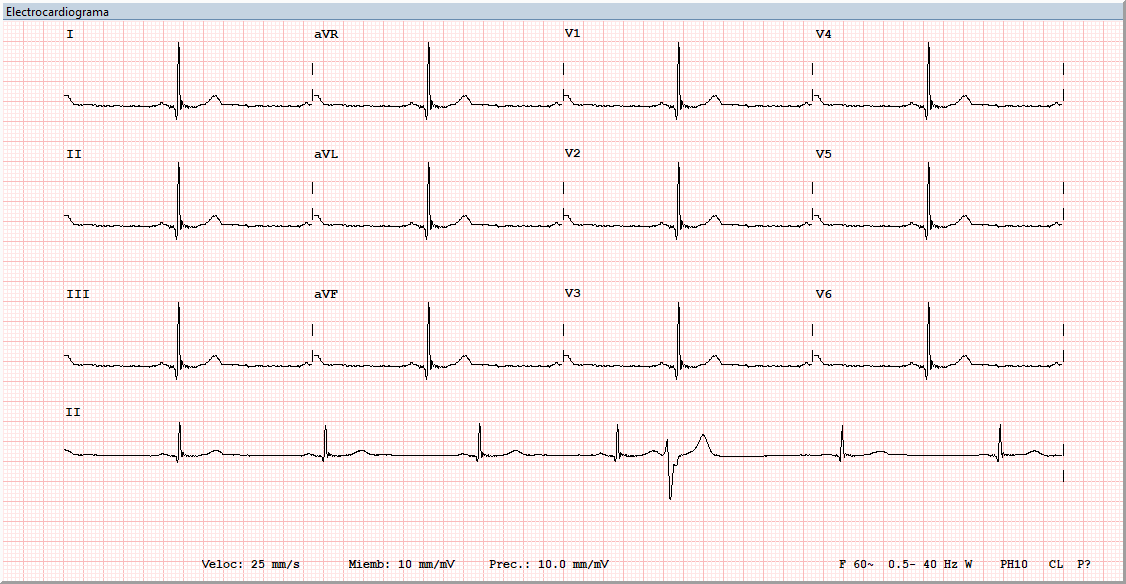

In [32]:
#lee la imagen del archivo txt con la codificación Base64
imagen_str = load_base64_from_txt('./imagen_base64_20.txt')

#Obtiene el vector y la frecuencia de muestreo
(vector, fs) = model_vectro_preprocess = process_image(imagen_str, 128,250)

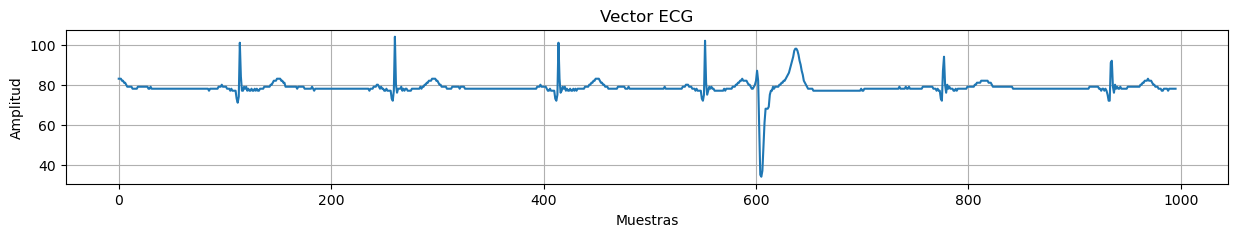

Frecuencia de muestreo:  99 Hz


In [33]:
#Graficamos el vector que se obtuvo de la imagen

grafica_vector(vector)
print('Frecuencia de muestreo: ',fs,'Hz')

### **Inicia el preprocesado del vector**

Gráfica de latidos con vector derivado


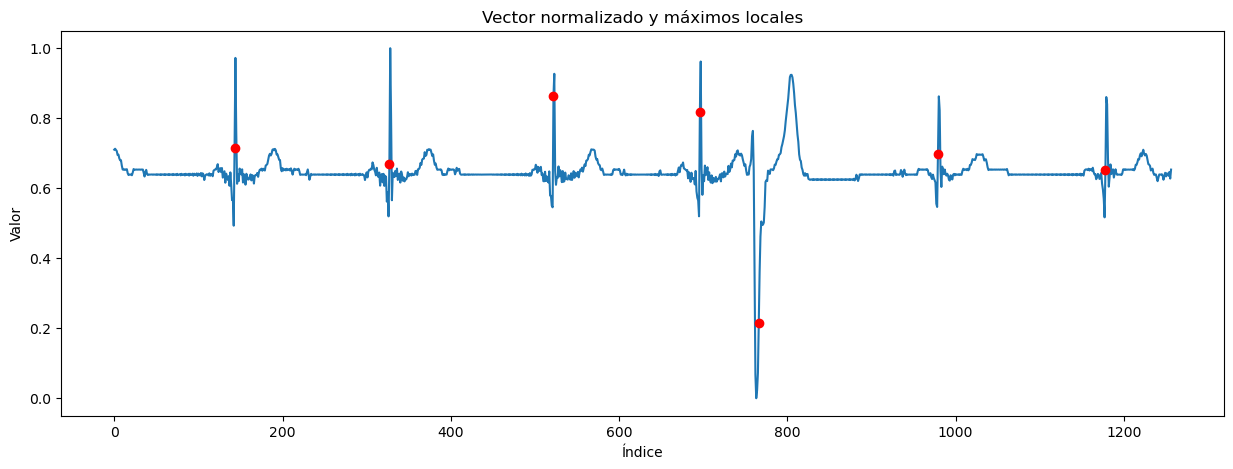

In [34]:
latidos = proceso_segmentacion(vector,fs,grafica=5)

In [49]:
modelo = load_model('./clasificador_ver5.h5')

def evalua(latidos):
    y_pred = modelo.predict(latidos, verbose=0)
    y_pred_classes = np.argmax(y_pred, axis=1)
    print('Total de latidos: ', latidos.shape[0])
    print('Clasificación de latidos: ', y_pred_classes)

#### **Codificación de las clases que devuelve el modelo**

#### **['N': 0, 'S': 1, 'V': 2, 'F': 3, 'Q': 4]

In [50]:
evalua(latidos)

Total de latidos:  6
Clasificación de latidos:  [0 0 0 0 1 0]
